# A/B Testing 
*Notes summarized from https://medium.com/@RenatoFillinich/ab-testing-with-python-e5964dd66143*
   
1. Designing our experiment
2. Collecting and preparing the data
3. Visualizing the results
4. Testing the hypothesis 
5. Drawing conclusions 

**Scenario**
- online ecommerce business 
- current conversion rate of product page: 13% on average throughout the year
- team would be happy with 2% increase (new design considered successful if it raises conversion rate to 15%) 

### 1. Designing our experiment

#### Formulating hypothesis   
Two-tailed test to see if new design will perform better or worse or the same:   
$H_{0}$: p = $p_{0}$   
$H_{a}$: p != $p_{0}$   
p is conversion rate of new design, $p_{0}$ is conversion rate of old design    

$\alpha$ = 0.05    
- if probability of observing a result as extreme or more (p-value) is lower than $\alpha$, then reject null.    

(our independent variable)   
Control: old design   
Test: new design    
   
(dependent variable - what we are tryna measure)   
conversion rate:   
- 0: user did not buy the product during this user session   
- 1: user bought the product during this user session    

#### Choosing sample size   
The number of people/user sessions we decide in each group will have an affect on the precision of our estimated conversion rates: the larger the sample size, the more precise our estimate (i.e. the smaller the C.I.), the higher the chance to detect a difference in two groups, if present.   
But also more expensive.   
   
#### Power analysis:    
- Power of the test (1 - $\beta$): probability of finding a statistical difference between the groups in our test when a difference is actually present (0.80 by convention)   
    - have 80% chance to detect it as statistically significant in our test with the sample size we will calculate 
- Alpha value: critical value (0.05)   
- Effect size: how big of a difference we expect there to be between the conversion rates  

In [4]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

# %matplotlib inline # will make your plot outputs appear and be stored within the notebook

In [5]:
effect_size = sms.proportion_effectsize(0.13, 0.15)
effect_size

-0.0576728617308947

What is ratio=1 in sample size calculation:   
The documentation from statsmodels defines it as "ratio of the number of observations in sample 2 relative to sample 1". Essentially, you input the sample size for group 1 in the function and indicate sample size for group 2 as a ratio of group 1. In this case they are the same, hence ratio=1

In [6]:
# for two sample 
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    ) # Calculating sample size needed

required_n = ceil(required_n) # Rounding up to next whole number                          

print(required_n) # required_n is the number needed for each group 

4720


### 2. Collecting and preparing the data

In [7]:
# see all objects in folder 
! ls

AB Testing and Predictive Modeling.ipynb
README.md
ab_data.csv


In [9]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [14]:
# check that TC group is getting the correct new vs old page 
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [18]:
session_counts = df['user_id'].value_counts(ascending=False) # counting num of appearances for each unique user 

multi_users = session_counts[session_counts > 1].count() # count the number of users that appeared more than once 

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


In [21]:
users_to_drop = session_counts[session_counts > 1].index # index of users that we are dropping 

df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 286690 entries


#### Sampling 
Setting random_state = 123 or some number to get reproducible results.   
<code>DataFrame.sample()</code> will perform simple random sampling.   

In [24]:
# perform simple random sampling 

control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=123) 
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=123)

In [26]:
ab_sample = pd.concat([control_sample, treatment_sample], axis=0)
ab_sample.reset_index(drop=True, inplace=True)

ab_sample.head()

,user_id,timestamp,group,landing_page,converted
0,689587,2017-01-13 11:17:53.637947,control,old_page,0
1,708802,2017-01-17 06:26:13.317907,control,old_page,0
2,734166,2017-01-09 03:16:50.487997,control,old_page,0
3,679205,2017-01-21 08:14:08.970343,control,old_page,0
4,664151,2017-01-10 09:55:59.891293,control,old_page,0


In [29]:
ab_sample['group'].value_counts()

treatment    4720
control      4720
Name: group, dtype: int64

#### 3. Visualizing the results 

ddof: Delta Degrees of Freedom   
The standard deviation is the square root of the average of the squared deviations from the mean, i.e., std = sqrt(mean(x)), where x = abs(a - a.mean())**2.   
   
The average squared deviation is typically calculated as x.sum() / N, where N = len(x). If, however, ddof is specified, the divisor N - ddof is used instead.   
    
In standard statistical practice, <code>ddof=1</code> provides an unbiased estimator of the variance of the infinite population.    
<code>ddof=0</code> provides a maximum likelihood estimate of the variance for normally distributed variables.   

- Include ddof=1 if you're calculating np.std() for a sample taken from your full dataset.
- Ensure ddof=0 if you're calculating np.std() for the full population

In [36]:
conversion_rates = ab_sample.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0) # standard deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0) # standard error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.119,0.324,0.005
treatment,0.120,0.325,0.005


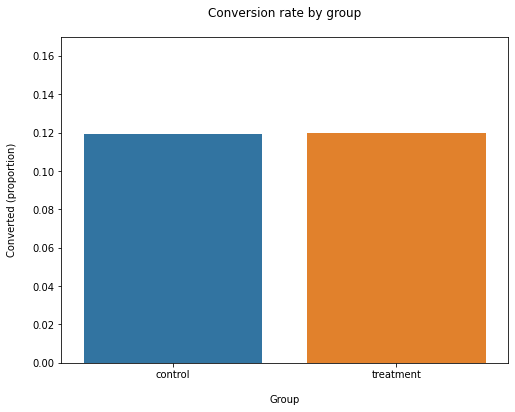

In [38]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_sample['group'], y=ab_sample['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

#### 4. Testing the hypothesis

We have a large sample - can use normal approximation (i.e. z-test) to calculate p-value. 

In [49]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [51]:
control_results = ab_sample[ab_sample['group'] == 'control']['converted'] # converted column for all controls 
treatment_results = ab_sample[ab_sample['group'] == 'treatment']['converted'] # converted column for all treatment 

n_con = control_results.count()
n_treat = treatment_results.count()

successes = [control_results.sum(), treatment_results.sum()] # count of converted users in control and treatment group
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs) 
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

In [52]:
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.10
p-value: 0.924
ci 95% for control group: [0.110, 0.128]
ci 95% for treatment group: [0.110, 0.129]


#### 5. Drawing conclusions

p-value is greater than $\alpha$ = 0.05, we fail to reject null. New design did not perform significantly different than our old one.    
   
Looking at CI for treatment group: [0.110, 0.129], it 1.) included baseline value of 13%, and 2.) it does not include our target value of 15%.   
This means that it is more likely that the true conversion rate of the new design is similar to baseline. 